In [1]:
library(tidyverse)
library(DESeq2)
library(sva)

source("../../utils/plots_eda.R")

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

In [2]:
# version of DESeq2
packageVersion("DESeq2")

# version of sva
packageVersion("sva")

[1] ‘1.38.0’

[1] ‘3.46.0’

# Load data

In [3]:
datasets <- c("GSE129508", "GSE58135", "GSE149276")

In [4]:
all_expression <- NULL
all_metadata <- NULL

for(dataset in datasets){
    metadata <- read.table(paste0("before/", dataset, "/", dataset, ".sample_info.tsv"), header = TRUE, sep = "\t")
    expr_data <- read.table(paste0("before/", dataset, "/", dataset, ".counts.tsv"), header = TRUE, sep = "\t")


    # if sample GCSM3714613 is in expression or metadata, remove it
    if("GSM3714613" %in% colnames(expr_data)){
        print(paste0("Removing sample GSM3714613 from ", dataset))
        expr_data <- expr_data[, -which(colnames(expr_data) == "GSM3714613")]
        metadata <- metadata[metadata$sample_id != "GSM3714613",]
    }
    
    metadata$Dataset <- dataset
    metadata <- metadata %>% 
        mutate(Status = ifelse(Basal == 1, "Basal", "Luminal")) %>%
            # ifelse(is_LumA == 1, "LumA", "LumB"))) %>%
        mutate(Status = as.factor(Status))

    print(paste0("Samples: ", nrow(metadata), "; Features: ", nrow(expr_data)))

    #########################################################################################################################
    # Normalization # 
    # Create a DESeq2 dataset object
    expr_data <- expr_data %>% column_to_rownames("gene_id")

    dds <- DESeqDataSetFromMatrix(countData = expr_data, colData = metadata, design = ~ Status)
    # Normalize using median of ratios method
    dds <- estimateSizeFactors(dds)
    normalized_counts <- counts(dds, normalized = TRUE)
    expr_data <- as.data.frame(normalized_counts) %>% 
        rownames_to_column("gene_id")
    print(paste0("Normalized Samples: ", nrow(metadata), "; Features: ", nrow(expr_data)))

    #########################################################################################################################
    #  plot
    plot_res <- plot_diagnostic(expr_data, metadata, dataset,
                                log_transform = FALSE, with_rowname = FALSE)
    layout <- (plot_res[[1]] + plot_res[[2]] ) / 
              (plot_res[[3]] )
    ggsave(paste0("before/", dataset, "/diagnostic_plot.png"), 
                plot = layout, width = 12, height = 12)

    # save data
    if(is.null(all_metadata)){
        all_metadata <- metadata
        all_expression <- expr_data
    } else {        
        all_metadata <- rbind(all_metadata, metadata)
        all_expression <- full_join(all_expression, expr_data, by = "gene_id")
    }
    print(paste0("Combined Samples: ", nrow(all_metadata), "; Features: ", nrow(all_expression)))
    print(" ")
}

# plot the combined data
print("Plotting combined data")
plot_res <- plot_diagnostic(all_expression, all_metadata, "Combined")
layout <- (plot_res[[1]] + plot_res[[2]] ) / 
          (plot_res[[3]] )
ggsave("before/diagnostic_plot.png", 
            plot = layout, width = 12, height = 12)

[1] "Removing sample GSM3714613 from GSE129508"
[1] "Samples: 25; Features: 35238"
[1] "Normalized Samples: 25; Features: 35238"
[1] "..plotting.."


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
No id variables; using all as measure variables



[1] "Combined Samples: 25; Features: 35238"
[1] " "
[1] "Samples: 75; Features: 35238"
[1] "Normalized Samples: 75; Features: 35238"
[1] "..plotting.."


No id variables; using all as measure variables



[1] "Combined Samples: 100; Features: 35238"
[1] " "
[1] "Samples: 31; Features: 35238"
[1] "Normalized Samples: 31; Features: 35238"
[1] "..plotting.."


No id variables; using all as measure variables



[1] "Combined Samples: 131; Features: 35238"
[1] " "
[1] "Plotting combined data"
[1] "..plotting.."


No id variables; using all as measure variables



# Correction

In [5]:
all_metadata %>%
    group_by(Dataset, Status) %>% summarise(n())

`summarise()` has grouped output by 'Dataset'. You can override using the
`.groups` argument.


Dataset,Status,n()
<chr>,<fct>,<int>
GSE129508,Basal,4
GSE129508,Luminal,21
GSE149276,Basal,17
GSE149276,Luminal,14
GSE58135,Basal,36
GSE58135,Luminal,39


In [6]:
all_metadata %>%
    group_by(Dataset) %>% summarise(n())

Dataset,n()
<chr>,<int>
GSE129508,25
GSE149276,31
GSE58135,75


In [7]:
print(paste0("Number of features before filtering: ", nrow(all_expression)))
all_expression <- na.omit(all_expression)
print(paste0("Number of features after filtering: ", nrow(all_expression)))
print(paste0("Number of samples: ", nrow(all_metadata)))

[1] "Number of features before filtering: 35238"


[1] "Number of features after filtering: 35238"
[1] "Number of samples: 131"


In [8]:
all_expression <- all_expression %>% column_to_rownames("gene_id")
all_expression <- all_expression[, all_metadata$sample_id]
all_expression <- log2(all_expression + 1)
print(paste0("Number of samples: ", nrow(all_metadata)))
print(paste0("Number of features: ", nrow(all_expression), "; Number of samples: ", ncol(all_expression)))

[1] "Number of samples: 131"
[1] "Number of features: 35238; Number of samples: 131"


In [9]:
design <- model.matrix(~all_metadata$Status)

corrected_expr <- sva::ComBat(dat = all_expression, 
                              batch = all_metadata$Dataset, 
                              mod = design)

corrected_expr <- as.data.frame(corrected_expr)

# plot the combined corrected data
print("Plotting combined corrected data")
plot_res <- plot_diagnostic(corrected_expr, all_metadata, "Combined Corrected",
                            log_transform = TRUE, with_rowname = TRUE)
layout <- (plot_res[[1]] + plot_res[[2]] ) / 
          (plot_res[[3]] )
ggsave("after/diagnostic_plot_corrected.png", 
            plot = layout, width = 12, height = 12)


Found 6415 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




[1] "Plotting combined corrected data"
[1] "..plotting.."


No id variables; using all as measure variables



# Save data for correction and after correction

In [10]:
all_metadata$batch <- as.numeric(as.factor(all_metadata$Dataset)) - 1
# all_metadata$batch <- 0
all_metadata$lum <- as.numeric(as.factor(all_metadata$Status))
all_metadata$lum = all_metadata$lum - 1

for (dataset in unique(all_metadata$Dataset)) {
    print(paste0("Save data prior to batch correction for ", dataset))
    dataset_metadata <- all_metadata[all_metadata$Dataset == dataset,]
    dataset_metadata <- dataset_metadata %>% select(sample_id, lum, batch)
    
    dataset_expression <- all_expression[, dataset_metadata$sample_id]
    dataset_expression <- dataset_expression %>% rownames_to_column("gene_id")
    
    write.table(dataset_metadata, 
        file = paste0("before/", dataset, "/design.tsv"), sep = "\t", quote = FALSE, row.names = FALSE)
    write.table(dataset_expression, 
        file = paste0("before/", dataset, "/expr_for_correction.tsv"), sep = "\t", quote = FALSE, row.names = FALSE)

}

write.table(all_metadata %>% select(sample_id, lum, batch), 
    file = "before/all_design.tsv", sep = "\t", quote = FALSE, row.names = FALSE)
write.table(all_expression %>% rownames_to_column("gene_id"),
    file = "before/all_expr_for_correction.tsv", sep = "\t", quote = FALSE, row.names = FALSE)
write.table(corrected_expr %>% rownames_to_column("gene_id"),
    file = "after/all_corrected_R_expr.tsv", sep = "\t", quote = FALSE, row.names = FALSE)

[1] "Save data prior to batch correction for GSE129508"
[1] "Save data prior to batch correction for GSE58135"
[1] "Save data prior to batch correction for GSE149276"


# Fed Correction ...

... after FC app ...

In [12]:
fed_expression <- NULL

path_to_fed <- "/home/yuliya/repos/cosybio/FedComBat/datasets/Breast_cancer_RNASeq/after/fed_res/"

for(i in 0:2){
    expr_data <- read.table(paste0(path_to_fed, i, "_bayes_data.csv"), header = TRUE, sep = ",")
    print(paste0("Samples: ", ncol(expr_data), "; Features: ", nrow(expr_data)))
    # save data
    if(is.null(fed_expression)){
        fed_expression <- expr_data
    } else {        
        fed_expression <- full_join(fed_expression, expr_data, by = "gene_id")
    }
    print(paste0("Combined Samples: ", ncol(fed_expression), "; Features: ", nrow(fed_expression)))
    print(" ")
}


[1] "Samples: 26; Features: 35238"
[1] "Combined Samples: 26; Features: 35238"
[1] " "
[1] "Samples: 32; Features: 35238"
[1] "Combined Samples: 57; Features: 35238"
[1] " "
[1] "Samples: 76; Features: 35238"
[1] "Combined Samples: 132; Features: 35238"
[1] " "


In [15]:

fed_expression <- fed_expression %>% column_to_rownames("gene_id") 
fed_expression <- fed_expression[, all_metadata$sample_id]

# plot the combined data
print("Plotting combined data")
plot_res <- plot_diagnostic(fed_expression, all_metadata, "FedCombat corrected",
                            log_transform = TRUE, with_rowname = TRUE)
layout <- (plot_res[[1]] + plot_res[[2]] ) / 
          (plot_res[[3]] )
ggsave("after/diagnostic_plot_correcter_Fed.png", 
            plot = layout, width = 12, height = 12)

[1] "Plotting combined data"


[1] "..plotting.."


No id variables; using all as measure variables



# Min Max and mean absolute error

In [17]:
corrected_expr <- as.data.frame(corrected_expr)
fed_expression <- fed_expression[rownames(corrected_expr), colnames(corrected_expr)]

In [29]:
# Calculate value-to-value mean, max, and mean absolute difference
mean_diff <- mean(as.matrix(abs(corrected_expr - fed_expression), na.rm = TRUE))
max_diff <- max(abs(corrected_expr - fed_expression), na.rm = TRUE)
min_diff <- min(abs(corrected_expr - fed_expression), na.rm = TRUE)

print(paste0("Min difference: ", min_diff))
print(paste0("Mean difference: ", mean_diff))
print(paste0("Max difference: ", max_diff))


[1] "Min difference: 0"
[1] "Mean difference: 0.38892337828645"
[1] "Max difference: 3.58996554293112"


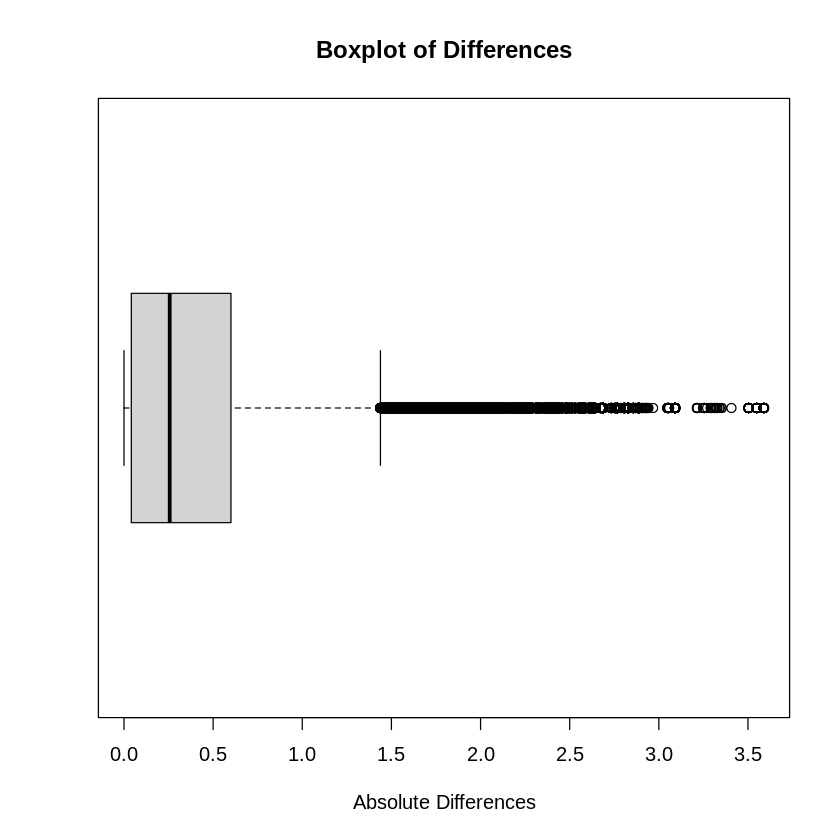

In [35]:
boxplot(abs(as.numeric(unlist(corrected_expr)) - as.numeric(unlist(fed_expression))),
        main = "Boxplot of Differences", xlab = "Absolute Differences",
        # add values to the plot - for the mean and the median
        horizontal = TRUE)